In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from keras.models import Sequential
# from keras.layers import LSTM, Activation, Dropout, Dense
# from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import numpy as np
import pickle

In [ ]:
data_train_path = "./weather_train.csv"
data_test_path = "./weather_test.csv"
pickle_path = "./scaler.pkl"

In [ ]:
with open(pickle_path, 'rb') as f:
    scaler = pickle.load(f)

In [ ]:
df_train = pd.read_csv(data_train_path)
df_train

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2009-01-01,00:00,patchy rain possible,-2.019447,1.604436,1.423837,1.718056,1.279488
1,2009-01-01,03:00,moderate rain at times,-1.814438,1.924270,1.423837,1.718056,1.677434
2,2009-01-01,06:00,heavy rain at times,-2.019447,2.033752,1.423837,1.718056,1.416617
3,2009-01-01,09:00,moderate rain at times,-1.814438,2.008139,1.423837,2.043605,1.677434
4,2009-01-01,12:00,moderate rain at times,-2.019447,1.973087,1.423837,1.718056,1.279488
...,...,...,...,...,...,...,...,...
37979,2021-12-31,09:00,moderate rain at times,-1.404419,1.973087,1.423837,2.043605,0.330110
37980,2021-12-31,12:00,heavy rain at times,-1.404419,2.033752,1.423837,1.880831,0.989629
37981,2021-12-31,15:00,heavy rain at times,-1.404419,2.067079,1.423837,1.555282,0.835818
37982,2021-12-31,18:00,heavy rain at times,-1.404419,2.077998,1.127571,1.718056,0.675204


In [ ]:
df_valid = df_train[df_train['Date'] >= '2019-01-01']
df_train = df_train[df_train['Date'] < '2019-01-01']

In [ ]:
df_test = pd.read_csv(data_test_path)
df_test

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2022-01-01,00:00,heavy rain at times,-1.609428,2.052764,0.949812,1.880831,0.143416
1,2022-01-01,03:00,patchy rain possible,-1.404419,1.374902,1.423837,1.718056,0.143416
2,2022-01-01,06:00,patchy rain possible,-1.404419,1.011483,1.423837,1.718056,0.143416
3,2022-01-01,09:00,patchy rain possible,-1.199410,1.374902,1.423837,2.043605,-0.054636
4,2022-01-01,12:00,patchy rain possible,-1.199410,1.604436,1.423837,1.718056,0.989629
...,...,...,...,...,...,...,...,...
8763,2024-12-31,09:00,light rain shower,-1.199410,1.754280,1.127571,1.880831,0.989629
8764,2024-12-31,12:00,light rain shower,-1.199410,1.604436,1.423837,1.555282,1.137325
8765,2024-12-31,15:00,light rain shower,-1.199410,1.011483,1.423837,1.066959,0.835818
8766,2024-12-31,18:00,patchy rain possible,-1.404419,0.413420,1.157198,1.229734,0.143416


In [ ]:
def format_date_time(df):
  if 'Date' in df.columns and 'Time' in df.columns:
    df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
    df = df.drop(columns=["Date", "Time"])
    df = df.set_index(pd.DatetimeIndex(df['Formatted Date']))
    df = df.drop('Formatted Date', axis=1)
    df = df.drop('Weather', axis=1)
    df.index.name = 'date'
    return df
  else:
    print("DataFrame không có cột 'Date' hoặc 'Time'.")
    return df

In [ ]:
df_train = format_date_time(df_train)
df_valid = format_date_time(df_valid)
df_test = format_date_time(df_test)

<ipython-input-6-faaa70da7b81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
<ipython-input-6-faaa70da7b81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)


In [ ]:
df_test

,Temp,Rain,Cloud,Pressure,Wind
date,,,,,
2022-01-01 00:00:00,-1.609428,2.052764,0.949812,1.880831,0.143416
2022-01-01 03:00:00,-1.404419,1.374902,1.423837,1.718056,0.143416
2022-01-01 06:00:00,-1.404419,1.011483,1.423837,1.718056,0.143416
2022-01-01 09:00:00,-1.199410,1.374902,1.423837,2.043605,-0.054636
2022-01-01 12:00:00,-1.199410,1.604436,1.423837,1.718056,0.989629
...,...,...,...,...,...
2024-12-31 09:00:00,-1.199410,1.754280,1.127571,1.880831,0.989629
2024-12-31 12:00:00,-1.199410,1.604436,1.423837,1.555282,1.137325
2024-12-31 15:00:00,-1.199410,1.011483,1.423837,1.066959,0.835818


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_hours = 8
n_features = 5
n_predict = 1

In [ ]:
def create_dataset(dataset, n_hours, n_features, n_predict):
    dataX, dataY = [], []

    data = dataset.values
    data = data.astype('float32')

    reframed = series_to_supervised(data, n_hours, n_predict)
    reframed = reframed.values

    dataX = reframed[:, :n_hours*n_features]
    dataY = reframed[:, -n_features]

    dataX = dataX.reshape(dataX.shape[0], n_hours, n_features)

    return dataX, dataY

In [ ]:
X_train, Y_train = create_dataset(df_train, n_hours, n_features, n_predict)
X_val, Y_val = create_dataset(df_valid, n_hours, n_features, n_predict)
X_test, Y_test = create_dataset(df_test, n_hours, n_features, n_predict)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(29208, 8, 5) (29208,)
(8760, 8, 5) (8760,)
(8760, 8, 5) (8760,)


## convert to torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train).unsqueeze(1)  # Add extra dimension for output
X_val_tensor = torch.FloatTensor(X_val)
Y_val_tensor = torch.FloatTensor(Y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.FloatTensor(Y_test).unsqueeze(1)

In [ ]:
# Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, fc1_size=256):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc1_size)
        self.dropout = nn.Dropout(0.2)
        self.out_layer = nn.Linear(fc1_size, 1)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take the last time step's output
        last_out = lstm_out[:, -1, :]

        # FC layers
        x = self.fc1(last_out)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.out_layer(x)
        return x

In [ ]:
# Initialize model
input_size = X_train.shape[2]  # Number of features
model = LSTMModel(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training parameters
n_epochs = 100
patience = 20
min_delta = 0.0001
best_val_loss = float('inf')
counter = 0

In [ ]:
# Tracking losses
train_losses = []
val_losses = []

In [ ]:
# Training loop
for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            # Load the best model
            model.load_state_dict(torch.load('best_model.pth'))
            break

# Evaluation on test set
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predictions.append(outputs.numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Convert predictions to numpy array
predictions = np.concatenate(predictions).flatten()

Epoch 1/100, Train Loss: 0.0943, Val Loss: 0.0369
Epoch 2/100, Train Loss: 0.0383, Val Loss: 0.0396
Epoch 3/100, Train Loss: 0.0353, Val Loss: 0.0309
Epoch 4/100, Train Loss: 0.0342, Val Loss: 0.0349
Epoch 5/100, Train Loss: 0.0328, Val Loss: 0.0314
Epoch 6/100, Train Loss: 0.0324, Val Loss: 0.0300
Epoch 7/100, Train Loss: 0.0316, Val Loss: 0.0310
Epoch 8/100, Train Loss: 0.0315, Val Loss: 0.0283
Epoch 9/100, Train Loss: 0.0310, Val Loss: 0.0287
Epoch 10/100, Train Loss: 0.0308, Val Loss: 0.0280
Epoch 11/100, Train Loss: 0.0303, Val Loss: 0.0348
Epoch 12/100, Train Loss: 0.0302, Val Loss: 0.0283
Epoch 13/100, Train Loss: 0.0299, Val Loss: 0.0290
Epoch 14/100, Train Loss: 0.0296, Val Loss: 0.0304
Epoch 15/100, Train Loss: 0.0294, Val Loss: 0.0277
Epoch 16/100, Train Loss: 0.0292, Val Loss: 0.0286
Epoch 17/100, Train Loss: 0.0290, Val Loss: 0.0311
Epoch 18/100, Train Loss: 0.0285, Val Loss: 0.0274
Epoch 19/100, Train Loss: 0.0290, Val Loss: 0.0281
Epoch 20/100, Train Loss: 0.0282, Val Lo

In [ ]:
predictions

array([-1.2495058, -1.2144623, -1.2435395, ..., -1.203263 , -1.2346373,
       -1.398196 ], dtype=float32)

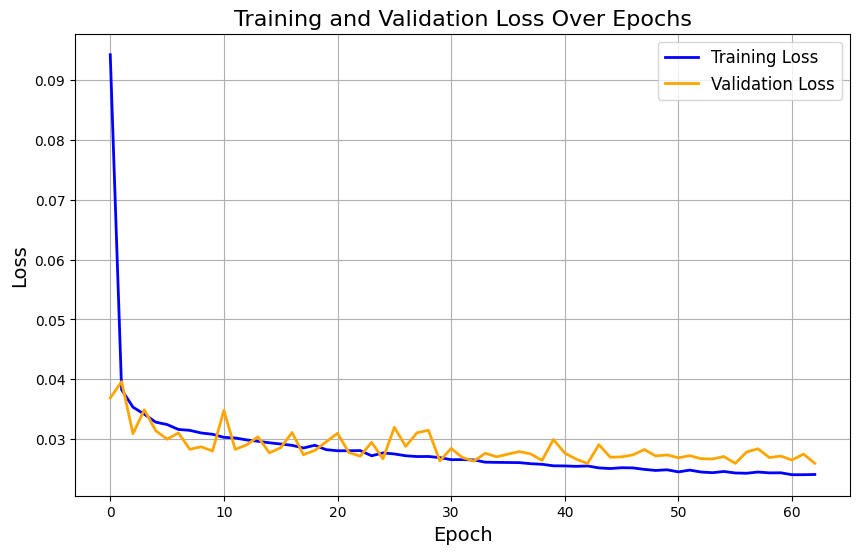

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [ ]:
torch.save(model.state_dict(), "lstm_model.pth")

In [ ]:
model.eval()
Y_test_predicted = []

with torch.no_grad():
    for batch_x, _ in test_loader:
        outputs = model(batch_x)
        Y_test_predicted.append(outputs.numpy())


In [ ]:
Y_test_predicted = np.concatenate(Y_test_predicted).flatten()

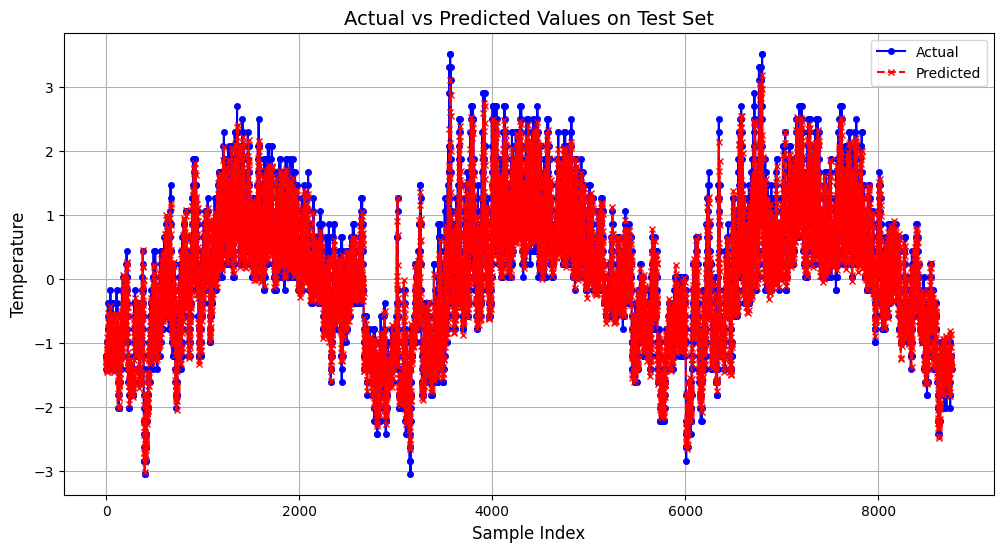

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(Y_test, label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted, label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

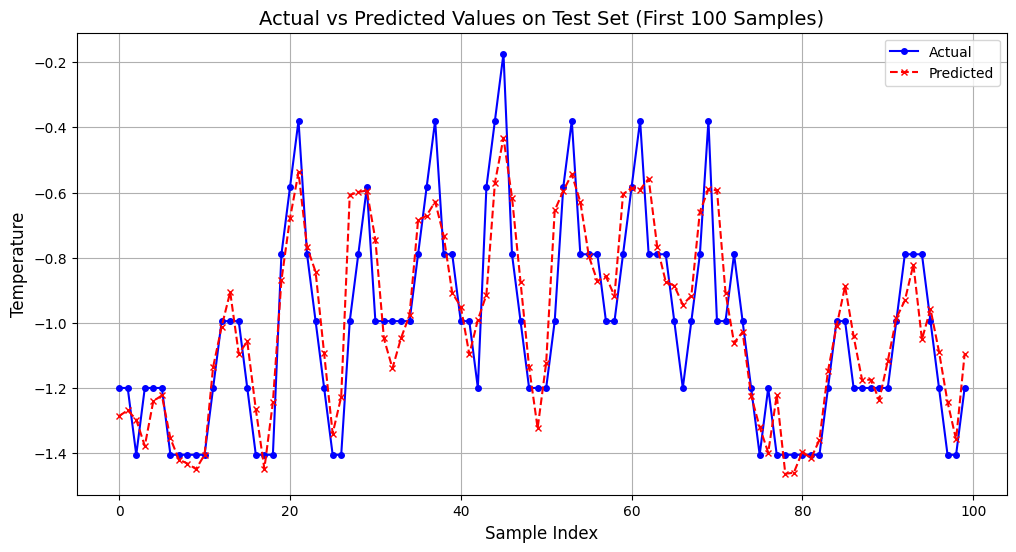

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test[:100], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted[:100], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)
plt.title('Actual vs Predicted Values on Test Set (First 100 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


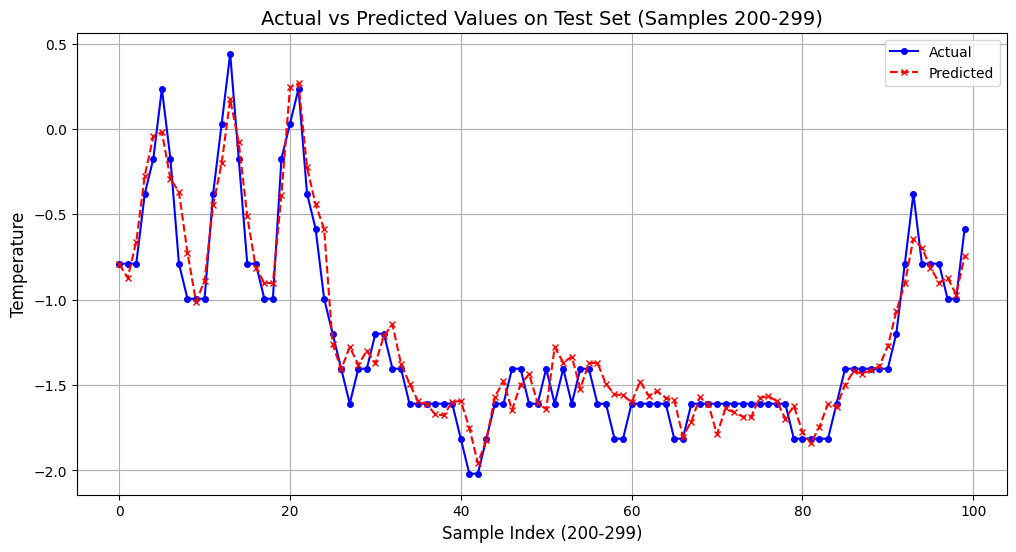

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test[200:300], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted[200:300], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)
plt.title('Actual vs Predicted Values on Test Set (Samples 200-299)', fontsize=14)
plt.xlabel('Sample Index (200-299)', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

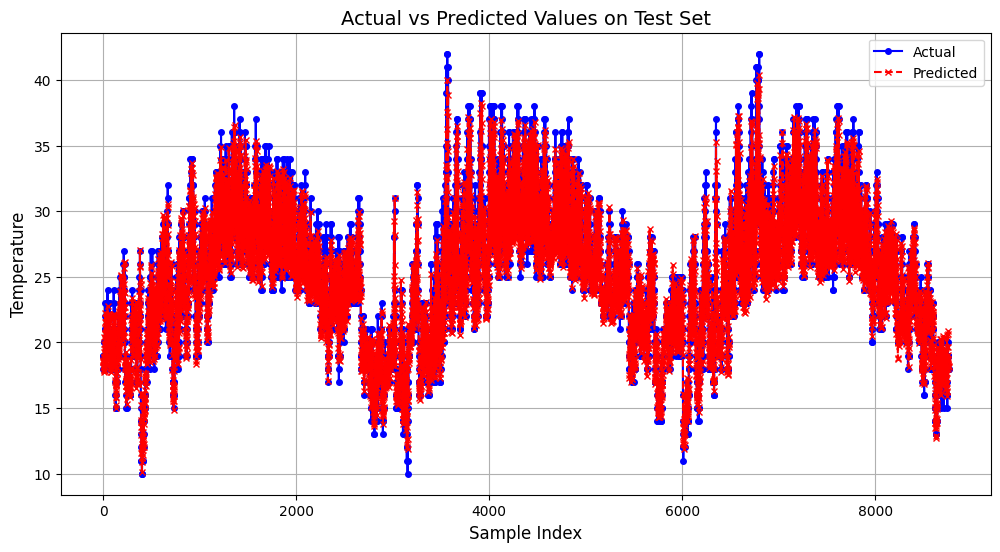

In [ ]:
X_test_np = X_test_tensor.numpy()
context_features = X_test_np[:, -1, -4:]  # shape (n_samples, 4)

inv_test_Y_predicted = np.concatenate((Y_test_predicted.reshape(-1, 1), context_features), axis=1)
inv_test_Y_predicted = scaler.inverse_transform(inv_test_Y_predicted)[:, 0]

inv_test_Y = np.concatenate((Y_test.reshape(-1, 1), context_features), axis=1)
inv_test_Y = scaler.inverse_transform(inv_test_Y)[:, 0]

# 4. Full prediction plot (after inverse transform)
plt.figure(figsize=(12, 6))
plt.plot(inv_test_Y, label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(inv_test_Y_predicted, label="Predicted", color='red', linestyle='--', marker='x', markersize=4)
plt.title('Actual vs Predicted Values on Test Set', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(inv_test_Y, inv_test_Y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_test_Y, inv_test_Y_predicted)
r2 = r2_score(inv_test_Y, inv_test_Y_predicted)

print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test R² Score: {r2:.3f}')

Test MSE: 0.900
Test RMSE: 0.949
Test MAE: 0.707
Test R² Score: 0.965
